# Import Packages 

In [ ]:
# run this cell

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive 
#from rdkit import Chem

# Cloning Repo

In [ ]:
!git clone https://github.com/595693085/DGraphDTA.git

Cloning into 'DGraphDTA'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (341/341), done.
remote: Total 372 (delta 105), reused 245 (delta 19), pack-reused 0
Receiving objects: 100% (372/372), 50.23 MiB | 5.62 MiB/s, done.
Resolving deltas: 100% (105/105), done.


# Preprocessed Data

In [ ]:
# to avoid the time to process the data

!gdown https://drive.google.com/uc?id=1rqAopf_IaH3jzFkwXObQ4i-6bUUwizCv
!unzip data.zip
!cp -r /content/data/davis/aln /content/DGraphDTA/data/davis
!cp -r /content/data/davis/pconsc4 /content/DGraphDTA/data/davis

In [ ]:
!rm data.zip

# Dependencies

In [ ]:
!pip3 install cairosvg
# !pip3 install numpy Cython pythran && pip3 install pconsc4
!pip install torch-geometric torch-scatter==latest+cu101 torch-sparse==latest+cu101 --no-cache-dir -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html


!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

     |████████████████████████████████| 3.6MB 7.2MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
  Created wheel for pythran: filename=pythran-0.9.5-cp36-none-any.whl size=4066521 sha256=0e1496b7eba8fe8090476d7c33fc4a5e712a2d6e5cfd5d31681b267299ab9aca
  Stored in directory: /root/.cache/pip/wheels/b5/4c/4f/3e8c360280dd141601ddc0cd9f243216f1ef90447faee31764
  Created wheel for beniget: filename=beniget-0.2.2-cp36-none-any.whl size=9382 sha256=4312ff9d918ca3d00d62232a16259802f588a009eb12d077cb9f0ebfd89ccde7
  Stored in directory: /root/.cache/pip/wheels/51/8a/9e/84a2b9ad3b89378e3b6553bf2033bc84afc38dc2d06f98f6f4
Successfully built pythran beniget
     |████████████████████████████████| 245.6MB 60kB/s 
     |████████████████████████████████| 3.8MB 34.1MB/s 
  Created wheel for pconsc4: filename=pconsc4-0.4-cp36-cp36m-linux_x86_64.whl size=242368212 sha256=861e2a28e0591de45216799c96e7bd072de69f0bad2e2b2fbadec20bd630c66f
  Stored in directory: /root/.cache/pip/wheels/85/b7/73/aa

# emetrics

In [ ]:
# run this cell

import numpy as np
import subprocess
from math import sqrt
from sklearn.metrics import average_precision_score
from scipy import stats
 
 
def get_aupr(Y, P, threshold=7.0):
    # print(Y.shape,P.shape)
    Y = np.where(Y >= 7.0, 1, 0)
    P = np.where(P >= 7.0, 1, 0)
    aupr = average_precision_score(Y, P)
    return aupr
 
 
def get_cindex(Y, P):
    summ = 0
    pair = 0
 
    for i in range(1, len(Y)):
        for j in range(0, i):
            if i is not j:
                if (Y[i] > Y[j]):
                    pair += 1
                    summ += 1 * (P[i] > P[j]) + 0.5 * (P[i] == P[j])
 
    if pair is not 0:
        return summ / pair
    else:
        return 0
 
 
def r_squared_error(y_obs, y_pred):
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    y_pred_mean = [np.mean(y_pred) for y in y_pred]
 
    mult = sum((y_pred - y_pred_mean) * (y_obs - y_obs_mean))
    mult = mult * mult
 
    y_obs_sq = sum((y_obs - y_obs_mean) * (y_obs - y_obs_mean))
    y_pred_sq = sum((y_pred - y_pred_mean) * (y_pred - y_pred_mean))
 
    return mult / float(y_obs_sq * y_pred_sq)
 
 
def get_k(y_obs, y_pred):
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
 
    return sum(y_obs * y_pred) / float(sum(y_pred * y_pred))
 
 
def squared_error_zero(y_obs, y_pred):
    k = get_k(y_obs, y_pred)
 
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    upp = sum((y_obs - (k * y_pred)) * (y_obs - (k * y_pred)))
    down = sum((y_obs - y_obs_mean) * (y_obs - y_obs_mean))
 
    return 1 - (upp / float(down))
 
 
def get_rm2(ys_orig, ys_line):
    r2 = r_squared_error(ys_orig, ys_line)
    r02 = squared_error_zero(ys_orig, ys_line)
 
    return r2 * (1 - np.sqrt(np.absolute((r2 * r2) - (r02 * r02))))
 
 
def get_rmse(y, f):
    rmse = sqrt(((y - f) ** 2).mean(axis=0))
    return rmse
 
 
def get_mse(y, f):
    mse = ((y - f) ** 2).mean(axis=0)
    return mse
 
 
def get_pearson(y, f):
    rp = np.corrcoef(y, f)[0, 1]
    return rp
 
 
def get_spearman(y, f):
    rs = stats.spearmanr(y, f)[0]
    return rs
 
 
def get_ci(y, f):
    ind = np.argsort(y)
    y = y[ind]
    f = f[ind]
    i = len(y) - 1
    j = i - 1
    z = 0.0
    S = 0.0
    while i > 0:
        while j >= 0:
            if y[i] > y[j]:
                z = z + 1
                u = f[i] - f[j]
                if u > 0:
                    S = S + 1
                elif u == 0:
                    S = S + 0.5
            j = j - 1
        i = i - 1
        j = i - 1
    ci = S / z
    return ci

# utils

In [ ]:
# run this cell

import os
from torch_geometric.data import InMemoryDataset, DataLoader, Batch
from torch_geometric import data as DATA
import torch
 
 
# initialize the dataset
class DTADataset(InMemoryDataset):
    def __init__(self, root='/tmp', dataset='davis',
                 xd=None, y=None, transform=None,
                 pre_transform=None, smile_graph=None, smile_image=None, target_key=None, target_graph=None):
 
        super(DTADataset, self).__init__(root, transform, pre_transform)
        self.dataset = dataset
        self.process(xd, target_key, y, smile_graph, smile_image, target_graph)
 
    @property
    def raw_file_names(self):
        pass
        # return ['some_file_1', 'some_file_2', ...]
 
    @property
    def processed_file_names(self):
        return [self.dataset + '_data_mol_i.pt', self.dataset + '_data_mol_g.pt',self.dataset + '_data_pro.pt']
 
    def download(self):
        # Download to `self.raw_dir`.
        pass
 
    def _download(self):
        pass
 
    def _process(self):
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir)
 
    def process(self, xd, target_key, y, smile_graph, smile_image, target_graph):
        assert (len(xd) == len(target_key) and len(xd) == len(y)), 'The three lists must be the same length!'
        data_list_mol_i = []
        data_list_mol_g = []
        data_list_pro = []
        data_len = len(xd)
        for i in range(data_len):
            smiles = xd[i]
            tar_key = target_key[i]
            labels = y[i]
            # convert SMILES to molecular representation using rdkit
            c_size, features, edge_index = smile_graph[smiles]
            #print('smile in utils', smiles)
 
            drug_image = smile_image[smiles]
            flatten = drug_image.reshape(1,300*100)
 
            target_size, target_features, target_edge_index = target_graph[tar_key]
            # print(np.array(features).shape, np.array(edge_index).shape)
            # print(target_features.shape, target_edge_index.shape)
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            GCNData_mol_i = DATA.Data(x=torch.Tensor(flatten),
                                    y=torch.FloatTensor([labels]))
            
            GCNData_mol_g = DATA.Data(x=torch.Tensor(features),
                                    edge_index=torch.LongTensor(edge_index).transpose(1, 0),
                                    y=torch.FloatTensor([labels]))
            GCNData_mol_g.__setitem__('c_size', torch.LongTensor([c_size]))
 
            GCNData_pro = DATA.Data(x=torch.Tensor(target_features),
                                    edge_index=torch.LongTensor(target_edge_index).transpose(1, 0),
                                    y=torch.FloatTensor([labels]))
            GCNData_pro.__setitem__('target_size', torch.LongTensor([target_size]))
            # print(GCNData.target.size(), GCNData.target_edge_index.size(), GCNData.target_x.size())
            data_list_mol_i.append(GCNData_mol_i)
            data_list_mol_g.append(GCNData_mol_g)
            data_list_pro.append(GCNData_pro)
 
        if self.pre_filter is not None:
            data_list_mol_i = [data for data in data_list_mol_i if self.pre_filter(data)]
            data_list_mol_g = [data for data in data_list_mol_g if self.pre_filter(data)]
            data_list_pro = [data for data in data_list_pro if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list_mol_i = [self.pre_transform(data) for data in data_list_mol_i]
            data_list_mol_g = [self.pre_transform(data) for data in data_list_mol_g]
            data_list_pro = [self.pre_transform(data) for data in data_list_pro]
        #self.data_mol_i = data_list_mol_i
        self.data_mol_i = data_list_mol_i
        self.data_mol_g = data_list_mol_g
        self.data_pro = data_list_pro
 
    def __len__(self):
        return len(self.data_mol_i)
 
    def __getitem__(self, idx):
        #mole_i = load_item(idx, self.data_mol_i)
        #mole_g = load_item(idx, self.data_mol_g)
        #pro_data = load_item(idx, self.data_pro)
        return self.data_mol_i[idx], self.data_mol_g[idx], self.data_pro[idx]
 
 
# training function at each epoch
def train(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()
    LOG_INTERVAL = 10
    TRAIN_BATCH_SIZE = 128
    loss_fn = torch.nn.MSELoss()
    for batch_idx, data in enumerate(train_loader):
        
        data_mol_i = data[0].to(device)
        data_mol_g = data[1].to(device)
        data_pro = data[2].to(device)
        optimizer.zero_grad()
        output = model(data_mol_i, data_mol_g, data_pro)
        loss = loss_fn(output, data_mol_g.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * TRAIN_BATCH_SIZE,
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))
 
# predict
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol_i = data[0].to(device)
            data_mol_g = data[1].to(device)
            data_pro = data[2].to(device)
            output = model(data_mol_i, data_mol_g, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol_g.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()
 
 
#prepare the protein and drug pairs
def collate(data_list):
    #print('data_list in collate',len(data_list[1]))
    batchA = Batch.from_data_list([data[0] for data in data_list])
    batchB = Batch.from_data_list([data[1] for data in data_list])
    batchC = Batch.from_data_list([data[2] for data in data_list])
    return batchA, batchB, batchC

# gnn

In [ ]:
# run this cell

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_max_pool as gmp, global_add_pool as gap,global_mean_pool as gep,global_sort_pool
from torch_geometric.utils import dropout_adj
 
 
# GCN based model
class GNNNet(torch.nn.Module):
    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78, output_dim=128, dropout=0.2):
        super(GNNNet, self).__init__()
 
        print('GNNNet Loaded')
        self.n_output = n_output
        self.mol_conv1_g = GCNConv(num_features_mol, num_features_mol)
        self.mol_conv2_g = GCNConv(num_features_mol, num_features_mol * 2)
        self.mol_conv3_g = GCNConv(num_features_mol * 2, num_features_mol * 4)
#-------------------------------------------------------------------------------
        self.mol_conv1 = nn.Conv2d(3, 32, 2)
        self.mol_bn1 = nn.BatchNorm2d(32)
        self.mol_conv2 = nn.Conv2d(32, 64, 2)
        self.mol_bn2 = nn.BatchNorm2d(64)
        self.mol_conv3 = nn.Conv2d(64, 128, 2)
        self.mol_bn3 = nn.BatchNorm2d(128)
        self.mol_conv4 = nn.Conv2d(128, 256, 2)
        self.mol_bn4 = nn.BatchNorm2d(256)
        self.mol_conv5 = nn.Conv2d(256, 512, 2)
        self.mol_bn5 = nn.BatchNorm2d(512)
 
        self.mol_pool = nn.MaxPool2d(2, 2)
        self.drop_rate = dropout
        self.mol_fc1 = nn.Linear(512*2*2, 512*2)
        self.mol_fc2 = nn.Linear(512*2, 256)
        self.mol_fc3 = nn.Linear(256, 128)
#-------------------------------------------------------------------------------
        self.mol_fc_g1 = torch.nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = torch.nn.Linear(1024, output_dim)
 
        # self.pro_conv1 = GCNConv(embed_dim, embed_dim)
        self.pro_conv1 = GCNConv(num_features_pro, num_features_pro)
        self.pro_conv2 = GCNConv(num_features_pro, num_features_pro * 2)
        self.pro_conv3 = GCNConv(num_features_pro * 2, num_features_pro * 4)
        # self.pro_conv4 = GCNConv(embed_dim * 4, embed_dim * 8)
        self.pro_fc_g1 = torch.nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = torch.nn.Linear(1024, output_dim)
 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
 
        # combined layers
        #self.fc1 = nn.Linear(1 * output_dim, 1024)    # 2*output_dim
        self.fc1 = nn.Linear(128 + output_dim+output_dim, 1024)    # 2*output_dim
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, self.n_output)
 
    def forward(self, data_mol, data_mol_g, data_pro):
       
        # get molecule image input
        mol_x_i, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch
        size_mol = mol_x_i
        size_mol = size_mol.cpu().numpy()
        size_mol = size_mol[:,0].size
       # mol_x = mol_x.reshape(size_mol[0],3,200,200)
        mol_x_i = torch.reshape(mol_x_i, (size_mol,3,100,100))
        #mol_x = mol_x.reshape(sample_size,3,200,200)
 
        # get graph input
        mol_x, mol_edge_index, mol_batch = data_mol_g.x, data_mol_g.edge_index, data_mol_g.batch
 
        # get protein input
        target_x, target_edge_index, target_batch = data_pro.x, data_pro.edge_index, data_pro.batch
 
        # target_seq=data_pro.target
#-------------------------------------------------------------------------------
        x_g = self.mol_conv1_g(mol_x, mol_edge_index)
        x_g = self.relu(x_g)
 
        #mol_edge_index, _ = dropout_adj(mol_edge_index, training=self.training)
        x_g = self.mol_conv2_g(x_g, mol_edge_index)
        x_g = self.relu(x_g)
 
        # mol_edge_index, _ = dropout_adj(mol_edge_index, training=self.training)
        x_g = self.mol_conv3_g(x_g, mol_edge_index)
        x_g = self.relu(x_g)
        x_g = gep(x_g, mol_batch)  # global pooling
 
        # flatten
        x_g = self.relu(self.mol_fc_g1(x_g))
        x_g = self.dropout(x_g)
        x_g = self.mol_fc_g2(x_g)
        x_g = self.dropout(x_g)
 
         # print(x.shape)
        x = self.mol_pool(F.relu(self.mol_bn1(self.mol_conv1(mol_x_i))))
        # print(x.shape)
        x = self.mol_pool(F.relu(self.mol_bn2(self.mol_conv2(x))))
        # print(x.shape)
        x = self.mol_pool(F.relu(self.mol_bn3(self.mol_conv3(x))))
        # print(x.shape)
        x = self.mol_pool(F.relu(self.mol_bn4(self.mol_conv4(x))))
        # print(x.shape)
        x = self.mol_pool(F.relu(self.mol_bn5(self.mol_conv5(x))))
        # print(x.shape)
 
       # x = x.view(-1, 32*5*5)
        x = x.view(x.size(0), -1)        
        x = F.dropout(F.relu(self.mol_fc1(x)), self.drop_rate)
        x = F.dropout(F.relu(self.mol_fc2(x)), self.drop_rate)
        x = self.mol_fc3(x)
#-------------------------------------------------------------------------------
        xt = self.pro_conv1(target_x, target_edge_index)
        xt = self.relu(xt)
 
        # target_edge_index, _ = dropout_adj(target_edge_index, training=self.training)
        xt = self.pro_conv2(xt, target_edge_index)
        xt = self.relu(xt)
 
        # target_edge_index, _ = dropout_adj(target_edge_index, training=self.training)
        xt = self.pro_conv3(xt, target_edge_index)
        xt = self.relu(xt)
 
        # xt = self.pro_conv4(xt, target_edge_index)
        # xt = self.relu(xt)
        xt = gep(xt, target_batch)  # global pooling
 
        # flatten
        xt = self.relu(self.pro_fc_g1(xt))
        xt = self.dropout(xt)
        xt = self.pro_fc_g2(xt)
        xt = self.dropout(xt)
 
        # print(x.size(), xt.size())
        # concat
        xc = torch.cat((x,x_g, xt), 1)
        # add some dense layers
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out

# process with Smile to Image generations

In [ ]:
# run this cell

import pandas as pd
import numpy as np
import os
import random
import json, pickle
from collections import OrderedDict
import networkx as nx
from rdkit.Chem import MolFromSmiles
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import DrawingOptions
import cairosvg
import sys
import cv2
import torch
import warnings
import subprocess
from operator import itemgetter
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, BatchSampler, SequentialSampler
 
# from utils import *
IMG_SIZE = 100
training_files_path = '/root/DGraphDTA/data/davis/SmileImages/'
 
# nomarlize
def dic_normalize(dic):
    # print(dic)
    max_value = dic[max(dic, key=dic.get)]
    min_value = dic[min(dic, key=dic.get)]
    # print(max_value)
    interval = float(max_value) - float(min_value)
    for key in dic.keys():
        dic[key] = (dic[key] - min_value) / interval
    dic['X'] = (max_value + min_value) / 2.0
    return dic
 
 
pro_res_table = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
                 'X']
 
pro_res_aliphatic_table = ['A', 'I', 'L', 'M', 'V']
pro_res_aromatic_table = ['F', 'W', 'Y']
pro_res_polar_neutral_table = ['C', 'N', 'Q', 'S', 'T']
pro_res_acidic_charged_table = ['D', 'E']
pro_res_basic_charged_table = ['H', 'K', 'R']
 
res_weight_table = {'A': 71.08, 'C': 103.15, 'D': 115.09, 'E': 129.12, 'F': 147.18, 'G': 57.05, 'H': 137.14,
                    'I': 113.16, 'K': 128.18, 'L': 113.16, 'M': 131.20, 'N': 114.11, 'P': 97.12, 'Q': 128.13,
                    'R': 156.19, 'S': 87.08, 'T': 101.11, 'V': 99.13, 'W': 186.22, 'Y': 163.18}
 
res_pka_table = {'A': 2.34, 'C': 1.96, 'D': 1.88, 'E': 2.19, 'F': 1.83, 'G': 2.34, 'H': 1.82, 'I': 2.36,
                 'K': 2.18, 'L': 2.36, 'M': 2.28, 'N': 2.02, 'P': 1.99, 'Q': 2.17, 'R': 2.17, 'S': 2.21,
                 'T': 2.09, 'V': 2.32, 'W': 2.83, 'Y': 2.32}
 
res_pkb_table = {'A': 9.69, 'C': 10.28, 'D': 9.60, 'E': 9.67, 'F': 9.13, 'G': 9.60, 'H': 9.17,
                 'I': 9.60, 'K': 8.95, 'L': 9.60, 'M': 9.21, 'N': 8.80, 'P': 10.60, 'Q': 9.13,
                 'R': 9.04, 'S': 9.15, 'T': 9.10, 'V': 9.62, 'W': 9.39, 'Y': 9.62}
 
res_pkx_table = {'A': 0.00, 'C': 8.18, 'D': 3.65, 'E': 4.25, 'F': 0.00, 'G': 0, 'H': 6.00,
                 'I': 0.00, 'K': 10.53, 'L': 0.00, 'M': 0.00, 'N': 0.00, 'P': 0.00, 'Q': 0.00,
                 'R': 12.48, 'S': 0.00, 'T': 0.00, 'V': 0.00, 'W': 0.00, 'Y': 0.00}
 
res_pl_table = {'A': 6.00, 'C': 5.07, 'D': 2.77, 'E': 3.22, 'F': 5.48, 'G': 5.97, 'H': 7.59,
                'I': 6.02, 'K': 9.74, 'L': 5.98, 'M': 5.74, 'N': 5.41, 'P': 6.30, 'Q': 5.65,
                'R': 10.76, 'S': 5.68, 'T': 5.60, 'V': 5.96, 'W': 5.89, 'Y': 5.96}
 
res_hydrophobic_ph2_table = {'A': 47, 'C': 52, 'D': -18, 'E': 8, 'F': 92, 'G': 0, 'H': -42, 'I': 100,
                             'K': -37, 'L': 100, 'M': 74, 'N': -41, 'P': -46, 'Q': -18, 'R': -26, 'S': -7,
                             'T': 13, 'V': 79, 'W': 84, 'Y': 49}
 
res_hydrophobic_ph7_table = {'A': 41, 'C': 49, 'D': -55, 'E': -31, 'F': 100, 'G': 0, 'H': 8, 'I': 99,
                             'K': -23, 'L': 97, 'M': 74, 'N': -28, 'P': -46, 'Q': -10, 'R': -14, 'S': -5,
                             'T': 13, 'V': 76, 'W': 97, 'Y': 63}
 
res_weight_table = dic_normalize(res_weight_table)
res_pka_table = dic_normalize(res_pka_table)
res_pkb_table = dic_normalize(res_pkb_table)
res_pkx_table = dic_normalize(res_pkx_table)
res_pl_table = dic_normalize(res_pl_table)
res_hydrophobic_ph2_table = dic_normalize(res_hydrophobic_ph2_table)
res_hydrophobic_ph7_table = dic_normalize(res_hydrophobic_ph7_table)
 
 
# print(res_weight_table)
 
 
def residue_features(residue):
    res_property1 = [1 if residue in pro_res_aliphatic_table else 0, 1 if residue in pro_res_aromatic_table else 0,
                     1 if residue in pro_res_polar_neutral_table else 0,
                     1 if residue in pro_res_acidic_charged_table else 0,
                     1 if residue in pro_res_basic_charged_table else 0]
    res_property2 = [res_weight_table[residue], res_pka_table[residue], res_pkb_table[residue], res_pkx_table[residue],
                     res_pl_table[residue], res_hydrophobic_ph2_table[residue], res_hydrophobic_ph7_table[residue]]
    # print(np.array(res_property1 + res_property2).shape)
    return np.array(res_property1 + res_property2)
 
 
# mol atom feature for mol graph
def atom_features(atom):
    # 44 +11 +11 +11 +1
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                          ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As',
                                           'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se',
                                           'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr',
                                           'Pt', 'Hg', 'Pb', 'X']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) +
                    [atom.GetIsAromatic()])
 
 
# one ont encoding
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        # print(x)
        raise Exception('input {0} not in allowable set{1}:'.format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))
 
 
def one_of_k_encoding_unk(x, allowable_set):
    '''Maps inputs not in the allowable set to the last element.'''
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))
 
 
# mol smile to mol graph edge index
def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)
 
    c_size = mol.GetNumAtoms()
 
    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append(feature / sum(feature))
 
    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    mol_adj = np.zeros((c_size, c_size))
    for e1, e2 in g.edges:
        mol_adj[e1, e2] = 1
        # edge_index.append([e1, e2])
    mol_adj += np.matrix(np.eye(mol_adj.shape[0]))
    index_row, index_col = np.where(mol_adj >= 0.5)
    for i, j in zip(index_row, index_col):
        edge_index.append([i, j])
    # print('smile_to_graph')
    # print(np.array(features).shape)
    return c_size, features, edge_index
 
 
# smile to images generation
def save_comp_imgs_from_smiles(comp_id ,smiles):
    mol = Chem.MolFromSmiles(smiles)
    DrawingOptions.atomLabelFontSize = 55
    DrawingOptions.dotsPerAngstrom = 100
    DrawingOptions.bondLineWidth = 1.5
    Draw.MolToFile(mol, os.path.join(training_files_path, "imgs", "{}.png".format(comp_id)), size= ( IMG_SIZE , IMG_SIZE ))
 
    file_path = os.path.join('/root/DGraphDTA/data/davis/SmileImages/imgs/', comp_id + '.png')
  #  print('file path', file_path)
    img_arr = cv2.imread(file_path)
    angle = random.randint(0,359)
    rows, cols, channel = img_arr.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
 
    img_arr = cv2.warpAffine(img_arr, rotation_matrix, (cols, rows), cv2.INTER_LINEAR,
                                                 borderValue=(255, 255, 255))  # cv2.BORDER_CONSTANT, 255)
 
    img_arr = np.array(img_arr) / 255.0
    img_arr = img_arr.transpose((2, 0, 1))
    new_img = img_arr[0]
    new_img = np.concatenate((new_img,img_arr[1]), axis = 0)
    new_img = np.concatenate((new_img,img_arr[2]), axis = 0)
    return new_img
 
# target feature for target graph
def PSSM_calculation(aln_file, pro_seq):
    pfm_mat = np.zeros((len(pro_res_table), len(pro_seq)))
    with open(aln_file, 'r') as f:
        line_count = len(f.readlines())
        for line in f.readlines():
            if len(line) != len(pro_seq):
                print('error', len(line), len(pro_seq))
                continue
            count = 0
            for res in line:
                if res not in pro_res_table:
                    count += 1
                    continue
                pfm_mat[pro_res_table.index(res), count] += 1
                count += 1
    # ppm_mat = pfm_mat / float(line_count)
    pseudocount = 0.8
    ppm_mat = (pfm_mat + pseudocount / 4) / (float(line_count) + pseudocount)
    pssm_mat = ppm_mat
    # k = float(len(pro_res_table))
    # pwm_mat = np.log2(ppm_mat / (1.0 / k))
    # pssm_mat = pwm_mat
    # print(pssm_mat)
    return pssm_mat
 
 
def seq_feature(pro_seq):
    pro_hot = np.zeros((len(pro_seq), len(pro_res_table)))
    pro_property = np.zeros((len(pro_seq), 12))
    for i in range(len(pro_seq)):
        # if 'X' in pro_seq:
        #     print(pro_seq)
        pro_hot[i,] = one_of_k_encoding(pro_seq[i], pro_res_table)
        pro_property[i,] = residue_features(pro_seq[i])
    return np.concatenate((pro_hot, pro_property), axis=1)
 
 
def target_feature(aln_file, pro_seq):
    pssm = PSSM_calculation(aln_file, pro_seq)
    other_feature = seq_feature(pro_seq)
    # print('target_feature')
    # print(pssm.shape)
    # print(other_feature.shape)
 
    # print(other_feature.shape)
    # return other_feature
    return np.concatenate((np.transpose(pssm, (1, 0)), other_feature), axis=1)
 
 
# target aln file save in data/dataset/aln
def target_to_feature(target_key, target_sequence, aln_dir):
    # aln_dir = 'data/' + dataset + '/aln'
    aln_file = os.path.join(aln_dir, target_key + '.aln')
    # if 'X' in target_sequence:
    #     print(target_key)
    feature = target_feature(aln_file, target_sequence)
    return feature
 
 
# pconsc4 predicted contact map save in data/dataset/pconsc4
def target_to_graph(target_key, target_sequence, contact_dir, aln_dir):
    target_edge_index = []
    target_size = len(target_sequence)
    # contact_dir = 'data/' + dataset + '/pconsc4'
    contact_file = os.path.join(contact_dir, target_key + '.npy')
    contact_map = np.load(contact_file)
    contact_map += np.matrix(np.eye(contact_map.shape[0]))
    index_row, index_col = np.where(contact_map >= 0.5)
    for i, j in zip(index_row, index_col):
        target_edge_index.append([i, j])
    target_feature = target_to_feature(target_key, target_sequence, aln_dir)
    target_edge_index = np.array(target_edge_index)
    return target_size, target_feature, target_edge_index
 
 
# to judge whether the required files exist
def valid_target(key, dataset):
    contact_dir = '/root/DGraphDTA/data/' + dataset + '/pconsc4'
    aln_dir = '/root/DGraphDTA/data/' + dataset + '/aln'
    contact_file = os.path.join(contact_dir, key + '.npy')
    aln_file = os.path.join(aln_dir, key + '.aln')
    # print(contact_file, aln_file)
    tc = 0
    nc = 0
    if os.path.exists(contact_file) and os.path.exists(aln_file):
        tc += 1
    #    print('true count', contact_file, aln_file)
        return True
    else:
        return False
 
 
def data_to_csv(csv_file, datalist):
    with open(csv_file, 'w') as f:
        f.write('compound_iso_smiles,target_sequence,target_key,affinity\n')
        for data in datalist:
            f.write(','.join(map(str, data)) + '\n')
 
 
def create_dataset_for_test(dataset):
    # load dataset
    dataset_path = '/root/DGraphDTA/data/' + dataset + '/'
    test_fold = json.load(open(dataset_path + 'folds/test_fold_setting1.txt'))
    ligands = json.load(open(dataset_path + 'ligands_can.txt'), object_pairs_hook=OrderedDict)
    proteins = json.load(open(dataset_path + 'proteins.txt'), object_pairs_hook=OrderedDict)
    affinity = pickle.load(open(dataset_path + 'Y', 'rb'), encoding='latin1')
    # load contact and aln
    msa_path = '/root/DGraphDTA/data/' + dataset + '/aln'
    contac_path = '/root/DGraphDTA/data/' + dataset + '/pconsc4'
    msa_list = []
    contact_list = []
    for key in proteins:
        msa_list.append(os.path.join(msa_path, key + '.aln'))
        contact_list.append(os.path.join(contac_path, key + '.npy'))
 
    drugs = []
    prots = []
    prot_keys = []
    drug_smiles = []
    # smiles
 
    drug_images = {}
    for d in ligands.keys():
        lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]), isomericSmiles=True)
        drugs.append(lg)
        drug_images[lg] = save_comp_imgs_from_smiles(d, lg)
        drug_smiles.append(ligands[d])
 
   # drug_images = np.array(drug_images)
    
    # seqs
    for t in proteins.keys():
        prots.append(proteins[t])
        prot_keys.append(t)
    if dataset == 'davis':
        affinity = [-np.log10(y / 1e9) for y in affinity]
    affinity = np.asarray(affinity)
 
    valid_test_count = 0
    rows, cols = np.where(np.isnan(affinity) == False)
    rows, cols = rows[test_fold], cols[test_fold]
    temp_test_entries = []
    print('testfold rows negth',len(rows))                 # should be removed
    print('testfold cols negth',len(cols))
    for pair_ind in range(len(rows)):
        # if the required files is not exist, then pass
        if not valid_target(prot_keys[cols[pair_ind]], dataset):
            continue
        ls = []
        ls += [drugs[rows[pair_ind]]]
        ls += [prots[cols[pair_ind]]]
        ls += [prot_keys[cols[pair_ind]]]
        ls += [affinity[rows[pair_ind], cols[pair_ind]]]
        temp_test_entries.append(ls)
        valid_test_count += 1
    csv_file = '/root/DGraphDTA/data/' + dataset + '_test.csv'
    data_to_csv(csv_file, temp_test_entries)
    print('dataset:', dataset)
    print('test entries:', len(test_fold), 'effective test entries', valid_test_count)
 
    compound_iso_smiles = drugs
    target_key = prot_keys
 
    # create smile graph
    smile_graph = {}
    for smile in compound_iso_smiles:
        g = smile_to_graph(smile)
        smile_graph[smile] = g
  #  print(smile_graph['CN1CCN(C(=O)c2cc3cc(Cl)ccc3[nH]2)CC1']) #for test
 
    # create target graph
    # print('target_key', len(target_key), len(set(target_key)))
    target_graph = {}
    
    for key in target_key:
        if not valid_target(key, dataset):  # ensure the contact and aln files exists
            continue
        g = target_to_graph(key, proteins[key], contac_path, msa_path)
        target_graph[key] = g
 
    # count the number of  proteins with aln and contact files
    print('effective drugs,effective prot:', len(smile_graph), len(target_graph))
    if len(smile_graph) == 0 or len(target_graph) == 0:
        raise Exception('no protein or drug, run the script for datasets preparation.')
 
    # 'data/davis_test.csv' or data/kiba_test.csv'
    df_test = pd.read_csv('/root/DGraphDTA/data/' + dataset + '_test.csv')
    test_drugs, test_prot_keys, test_Y = list(df_test['compound_iso_smiles']), list(df_test['target_key']), list(
        df_test['affinity'])
    test_drugs, test_prot_keys, test_Y = np.asarray(test_drugs), np.asarray(test_prot_keys), np.asarray(test_Y)
    test_dataset = DTADataset(root='data', dataset=dataset + '_test', xd=test_drugs, y=test_Y,
                              target_key=test_prot_keys, smile_graph=smile_graph, smile_image=drug_images, target_graph=target_graph)
 
    return test_dataset
 
 
def create_dataset_for_5folds(dataset, fold=0):
    # load dataset
    dataset_path = '/root/DGraphDTA/data/' + dataset + '/'
    train_fold_origin = json.load(open(dataset_path + 'folds/train_fold_setting1.txt'))
    train_fold_origin = [e for e in train_fold_origin]  # for 5 folds
 
    ligands = json.load(open(dataset_path + 'ligands_can.txt'), object_pairs_hook=OrderedDict)
    proteins = json.load(open(dataset_path + 'proteins.txt'), object_pairs_hook=OrderedDict)
    # load contact and aln
    msa_path = '/root/DGraphDTA/data/' + dataset + '/aln'
    contac_path = '/root/DGraphDTA/data/' + dataset + '/pconsc4'
    msa_list = []
    contact_list = []
    for key in proteins:
        msa_list.append(os.path.join(msa_path, key + '.aln'))
        contact_list.append(os.path.join(contac_path, key + '.npy'))
  
    # load train,valid and test entries
    train_folds = []
    valid_fold = train_fold_origin[fold]  # one fold
    for i in range(len(train_fold_origin)):  # other folds
        if i != fold:
            train_folds += train_fold_origin[i]
    print('train Folds values', len(train_folds))
    affinity = pickle.load(open(dataset_path + 'Y', 'rb'), encoding='latin1')
    drugs = []
    prots = []
    prot_keys = []
    drug_smiles = []
    drugs_keys = []
    # smiles
    drug_images = {}
    for d in ligands.keys():
        lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]), isomericSmiles=True)
        drugs.append(lg)
        drug_images[lg] = save_comp_imgs_from_smiles(d, lg)
        drug_smiles.append(ligands[d])
        drugs_keys.append(d)
 
    # seqs
    for t in proteins.keys():
        prots.append(proteins[t])
        prot_keys.append(t)
    
    if dataset == 'davis':
        affinity = [-np.log10(y / 1e9) for y in affinity]
    affinity = np.asarray(affinity)
 
    opts = ['train', 'valid']
    valid_train_count = 0
    valid_valid_count = 0
    for opt in opts:
        if opt == 'train':
            rows, cols = np.where(np.isnan(affinity) == False)
            rows, cols = rows[train_folds], cols[train_folds]
            train_fold_entries = []
            for pair_ind in range(len(rows)):
                if not valid_target(prot_keys[cols[pair_ind]], dataset):  # ensure the contact and aln files exists
                    continue
                ls = []
                
                ls += [drugs[rows[pair_ind]]]
                ls += [prots[cols[pair_ind]]]
                ls += [prot_keys[cols[pair_ind]]]
                ls += [affinity[rows[pair_ind], cols[pair_ind]]]
           #     ls += [drugs_keys[rows[pair_ind]]]
                train_fold_entries.append(ls)
                valid_train_count += 1
 
            csv_file = '/root/DGraphDTA/data/' + dataset + '_' + 'fold_' + str(fold) + '_' + opt + '.csv'
            data_to_csv(csv_file, train_fold_entries)
        elif opt == 'valid':
            rows, cols = np.where(np.isnan(affinity) == False)
            rows, cols = rows[valid_fold], cols[valid_fold]
            valid_fold_entries = []
            for pair_ind in range(len(rows)):
                if not valid_target(prot_keys[cols[pair_ind]], dataset):
                    continue
                ls = []
                
                ls += [drugs[rows[pair_ind]]]
                ls += [prots[cols[pair_ind]]]
                ls += [prot_keys[cols[pair_ind]]]
                ls += [affinity[rows[pair_ind], cols[pair_ind]]]
           #     ls += [drugs_keys[rows[pair_ind]]]
                valid_fold_entries.append(ls)
                valid_valid_count += 1
 
            csv_file = '/root/DGraphDTA/data/' + dataset + '_' + 'fold_' + str(fold) + '_' + opt + '.csv'
            data_to_csv(csv_file, valid_fold_entries)
    print('dataset:', dataset)
    # print('len(set(drugs)),len(set(prots)):', len(set(drugs)), len(set(prots)))
 
    # entries with protein contact and aln files are marked as effiective
    print('fold:', fold)
    #print('train entries:', len(train_folds), 'effective train entries', valid_train_count)
    #print('valid entries:', len(valid_fold), 'effective valid entries', valid_valid_count)
    print('train entries:', len(train_folds), 'effective train entries', len(train_fold_entries))
    print('valid entries:', len(valid_fold), 'effective valid entries', len(valid_fold_entries))
 
    compound_iso_smiles = drugs
    target_key = prot_keys
    
    # create smile graph
    smile_graph = {}
    for smile in compound_iso_smiles:
        g = smile_to_graph(smile)
        smile_graph[smile] = g
    # print(smile_graph['CN1CCN(C(=O)c2cc3cc(Cl)ccc3[nH]2)CC1']) #for test
 
    # create target graph
    # print('target_key', len(target_key), len(set(target_key)))
    target_graph = {}
    for key in target_key:
        if not valid_target(key, dataset):  # ensure the contact and aln files exists
            continue
        g = target_to_graph(key, proteins[key], contac_path, msa_path)
        target_graph[key] = g
 
    # count the number of  proteins with aln and contact files
    print('effective drugs,effective prot:', len(smile_graph), len(target_graph))
    if len(smile_graph) == 0 or len(target_graph) == 0:
        raise Exception('no protein or drug, run the script for datasets preparation.')
 
    # 'data/davis_fold_0_train.csv' or data/kiba_fold_0__train.csv'
    train_csv = '/root/DGraphDTA/data/' + dataset + '_' + 'fold_' + str(fold) + '_' + 'train' + '.csv'
    df_train_fold = pd.read_csv(train_csv)
    train_drugs, train_prot_keys, train_Y = list(df_train_fold['compound_iso_smiles']), list(
        df_train_fold['target_key']), list(df_train_fold['affinity'])
    
 
    train_drugs, train_prot_keys, train_Y = np.asarray(train_drugs), np.asarray(train_prot_keys), np.asarray(train_Y)
    train_dataset = DTADataset(root='data', dataset=dataset + '_' + 'train', xd=train_drugs, target_key=train_prot_keys,
                               y=train_Y, smile_graph=smile_graph, smile_image=drug_images, target_graph=target_graph)
 
 
    df_valid_fold = pd.read_csv('/root/DGraphDTA/data/' + dataset + '_' + 'fold_' + str(fold) + '_' + 'valid' + '.csv')
    valid_drugs, valid_prots_keys, valid_Y = list(df_valid_fold['compound_iso_smiles']), list(
        df_valid_fold['target_key']), list(df_valid_fold['affinity'])
    valid_drugs, valid_prots_keys, valid_Y = np.asarray(valid_drugs), np.asarray(valid_prots_keys), np.asarray(
        valid_Y)
    valid_dataset = DTADataset(root='/root/DGraphDTA/data/', dataset=dataset + '_' + 'train', xd=valid_drugs,
                               target_key=valid_prots_keys, y=valid_Y, smile_graph=smile_graph, smile_image=drug_images,
                               target_graph=target_graph)
    return train_dataset, valid_dataset

In [ ]:
# run this cell

!mkdir /root/DGraphDTA/data/davis/SmileImages
!mkdir /root/DGraphDTA/data/davis/SmileImages/imgs

# training_5folds

In [ ]:
# run this cell

import sys, os
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader
 
# from gnn import GNNNet
# from utils import *
# from emetrics import *
# from data_process import create_dataset_for_5folds
 
 
datasets = ['davis']
 
cuda_name = 'cuda:0'
print('cuda_name:', cuda_name)
fold = 1 # [0, 1, 2, 3, 4][int(sys.argv[3])]
cross_validation_flag = True
# print(int(sys.argv[3]))
 
TRAIN_BATCH_SIZE = 384
TEST_BATCH_SIZE = 384
LR = 0.008
NUM_EPOCHS = 2000
 
print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)
 
models_dir = '/content/gdrive/My Drive/DL_Project_local/models'
results_dir = '/content/gdrive/My Drive/DL_Project_local/results/'
 
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
 
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
 
# Main program: iterate over different datasets
result_str = ''
USE_CUDA = torch.cuda.is_available()
device = torch.device(cuda_name if USE_CUDA else 'cpu')
model = GNNNet()
#dummy = torch.load('/content/gdrive/My Drive/DL_Project_local/models/model_GNNNet_CNN_davis_1_0218_282_228epochs_100Image_newModel_p3.model', map_location=cuda_name)
#model.load_state_dict(dummy['state_dict'])
 
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#optimizer.load_state_dict(dummy['optimizer'])
model_st = GNNNet.__name__

loss_fn = nn.MSELoss()
 
loss_mse = []
for dataset in datasets:
    #train_data, valid_data = create_dataset_for_5folds(dataset, fold)
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
    #                                           collate_fn=collate)
    #valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
    #                                           collate_fn=collate)
 
    best_mse = 1000
    best_test_mse = 1000
    best_epoch = -1
    #model_file_name = '/content/gdrive/My Drive/DL_Project/' + model_st + '_' + dataset + '_' + str(fold) + '.model'
    model_file_name = os.path.join(models_dir,'model_' + model_st + '_' + 'CNN' + '_' + dataset + '_' + str(fold) + '.model')
    for epoch in range(NUM_EPOCHS):

        train_data, valid_data = create_dataset_for_5folds(dataset, fold)
        train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                               collate_fn=collate)
        valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                               collate_fn=collate)
    
        train(model, device, train_loader, optimizer, epoch + 1)
        print('predicting for valid data')
        G, P = predicting(model, device, valid_loader)
        val = get_mse(G, P)
        loss_mse.append(val)
        print('valid result:', val, best_mse)
        if val < best_mse:
            best_mse = val
            best_epoch = epoch + 1
             #########################
            state = {
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }
            torch.save(state, model_file_name)
            #########################
            np.save(results_dir+'CNN_GNN',np.array(loss_mse))
            
            #torch.save(model.state_dict(), model_file_name)
            print('rmse improved at epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)
        else:
            print('No improvement since epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)

cuda_name: cuda:0
Learning rate:  0.008
Epochs:  2000
GNNNet Loaded
train Folds values 20037
dataset: davis
fold: 1
train entries: 20037 effective train entries 10000
valid entries: 5009 effective valid entries 5009
effective drugs,effective prot: 68 442
Training on 10000 samples...
Train epoch: 1 [0/10000 (0%)]	Loss: 30.662472
Train epoch: 1 [1280/10000 (37%)]	Loss: 8.253242
Train epoch: 1 [2560/10000 (74%)]	Loss: 4.057731
predicting for valid data
Make prediction for 5009 samples...
valid result: 6.108784 1000
rmse improved at epoch  1 ; best_test_mse 6.108784 GNNNet davis 1
train Folds values 20037
dataset: davis
fold: 1
train entries: 20037 effective train entries 10000
valid entries: 5009 effective valid entries 5009
effective drugs,effective prot: 68 442
Training on 10000 samples...
Train epoch: 2 [0/10000 (0%)]	Loss: 3.221485
Train epoch: 2 [1280/10000 (37%)]	Loss: 2.497167
Train epoch: 2 [2560/10000 (74%)]	Loss: 2.181303
predicting for valid data
Make prediction for 5009 sample

# test 

dataset: davis
cuda_name: cpu
GNNNet Loaded
testfold rows negth 5010
testfold cols negth 5010
dataset: davis
test entries: 5010 effective test entries 5010
effective drugs,effective prot: 68 442
Make prediction for 5010 samples...


No handles with labels found to put in legend.


metrics for  davis
cindex: 0.7712995257328518
cindex2 0.7743490131532095
rm2: 0.28761782003327374
mse: 0.5614629
pearson 0.5893391653329082
davis
rmse:0.7493082671243579  mse:0.5614629  pearson:0.5893391653329082 spearman:0.5063924579521937 ci:0.7712995257328518 rm2:0.28761782003327374


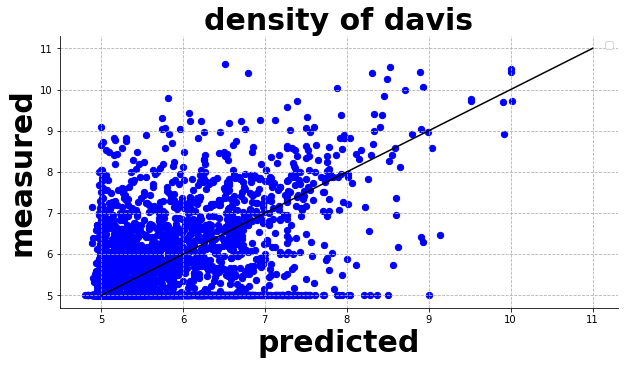

In [ ]:
import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch
 
# from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
# from utils import *
from scipy import stats
# from gnn import GNNNet
# from data_process import create_dataset_for_test
 
 
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol_i = data[0].to(device)
            data_mol_g = data[1].to(device)
            data_pro = data[2].to(device)
            # data = data.to(device)
            output = model(data_mol_i, data_mol_g, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol_g.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()
 
 
def load_model(model_path):
    model = torch.load(model_path)
    return model
 
 
def calculate_metrics(Y, P, dataset='davis'):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)
 
    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)
 
    result_file_name = '/content/gdrive/My Drive/DL_Project_local/results/NewModel_Image_GCN' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)
 
 
def plot_density(Y, P, fold=0, dataset='davis'):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
 
    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join('/content/gdrive/My Drive/DL_Project_local/results', 'NewModel_Image_GCN' + dataset + '_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')
 
 
if __name__ == '__main__':
    dataset = 'davis'  # dataset selection
    model_st = GNNNet.__name__
    print('dataset:', dataset)
 
    cuda_name = 'cpu'#'cuda:0'  # gpu selection
    print('cuda_name:', cuda_name)
 
    TEST_BATCH_SIZE = 384
    fold = 1
    models_dir = 'models'
    results_dir = 'results'
 
    device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
    model_file_name = '/root/DGraphDTA/models/model_' + model_st + '_' + dataset + '.model'
    result_file_name = '/root/DGraphDTA/results/result_' + model_st + '_' + dataset + '.txt'
    
 
    model = GNNNet()
    model.to(device)
    dummy = torch.load('/content/gdrive/My Drive/DL_Project_local/models/model_GNNNet_CNN_davis_1_0218_282_228epochs_100Image_newModel_p3.model', map_location=cuda_name)
    model.load_state_dict(dummy['state_dict'])
    
    #model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
    
    test_data = create_dataset_for_test(dataset)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)
    #test_data, dum = create_dataset_for_5folds(dataset, fold)
    #test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
    #                                          collate_fn=collate)
    #Y, P = predicting(model, device, test_loader)
    #vv = pd.DataFrame(P, Y)
    #vv.to_csv('/content/gdrive/My Drive/DL_Project/Drug_Images_generated_BA_Train.csv')
    #test_loader = torch.utils.data.DataLoader(dum, batch_size=TEST_BATCH_SIZE, shuffle=False,
    #                                          collate_fn=collate)
    Y, P = predicting(model, device, test_loader)
   # vv_v = pd.DataFrame(P, Y)
   # vv_v.to_csv('/content/gdrive/My Drive/DL_Project/generated_BA_Valid.csv')
    calculate_metrics(Y, P, dataset)
    plot_density(Y, P,0, dataset)